In [230]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

from keras import layers
from keras import optimizers

from keras.models import Model
from keras.models import Input

# from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics

from Preprocess import Preprocess

import pandas as pd
import numpy as np
from nltk import word_tokenize

from tensorflow_addons.layers import CRF 

In [231]:
train = '../data/ner-disease/train.iob'
test = '../data/ner-disease/test.iob' 
dev = '../data/ner-disease/dev.iob'
dev_predicted = '../data/ner-disease/dev-predicted.iob'


preprocess = Preprocess()
preprocess.text_to_data(filepath=train)
X, y = preprocess.preprocess_data()
preprocess.text_to_data(filepath=test)
Xtest, y_true = preprocess.preprocess_data()

In [232]:
df = pd.DataFrame(columns=['Sentence', 'Word', 'POS', 'Tag'])
df['Word'] = X
df['Tag'] = y

In [233]:
for i in range(len(df['Word'])):
    item = df['Word'][i]
    tag = nltk.pos_tag([item])
    df['POS'][i] = tag[0][1]

In [234]:
df['Sentence'][0] = 'Sentence: '+ str(1)
k = 2

for i in range(len(df['Word'])):
    if df['Word'][i] == '.':
        df['Sentence'][i+1] = 'Sentence: ' + str(k)
        k+=1        

In [235]:
dfnew = df.copy()

In [236]:
# dfnew['Sentence'] = dfnew['Sentence'].astype(str)

In [237]:
dfnew = dfnew.fillna(method="ffill")
dfnew["Sentence"] = dfnew["Sentence"].apply(lambda s: s[9:])
# dfnew["Sentence"] = dfnew["Sentence"].astype("int32")
dfnew.head()

,Sentence,Word,POS,Tag
0,1,Identification,NN,|O\n
1,1,of,IN,|O\n
2,1,"APC2,",NN,|O\n
3,1,a,DT,|O\n
4,1,homologue,NN,|O\n


In [238]:
dfnew.to_csv('../data/ner-disease/DatasetTrain.csv')

In [239]:
print("Total number of sentences in the dataset: {:,}".format(dfnew["Sentence"].nunique()))
print("Total words in the dataset: {:,}".format(dfnew.shape[0]))

Total number of sentences in the dataset: 5,863
Total words in the dataset: 128,721


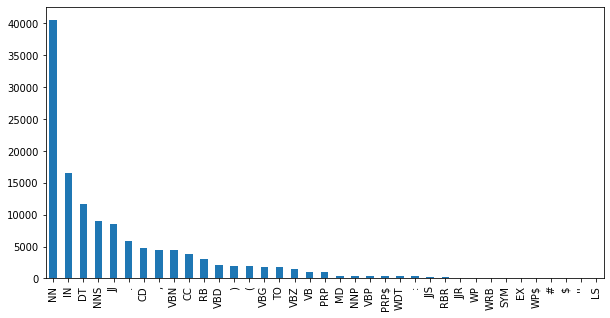

In [240]:
dfnew["POS"].value_counts().plot(kind="bar", figsize=(10,5));

<AxesSubplot:>

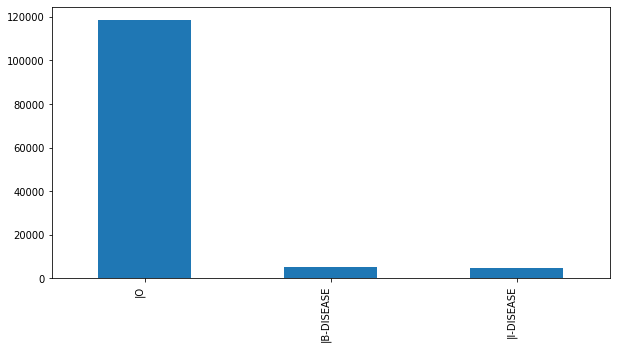

In [241]:
dfnew[dfnew["Tag"]!="O"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

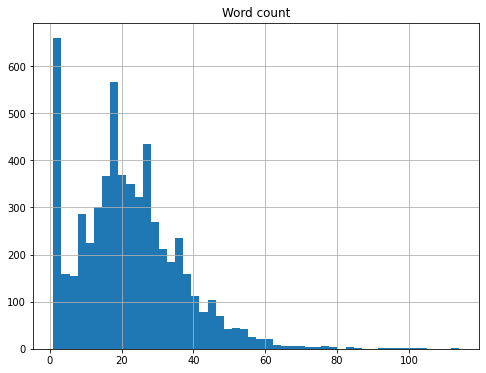

In [242]:
word_counts = dfnew.groupby("Sentence")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

In [243]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 114 words.


In [244]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

ID of the longest sentence is  2985.


In [245]:
longest_sentence = dfnew[dfnew["Sentence"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

The longest sentence in the corpus is:

These data demonstrate that 1 ) type I human complement C2 deficiency is caused by a 28-base pair genomic deletion that causes skipping of exon 6 during RNA splicing , resulting in generation of a premature termination codon , 2 ) the 28-base pair deletion in the type I C2Q0 gene is strongly associated with the HLA haplotype / complotype A25 , B18 , C2Q0 , BfS , C4A4 , C4B2 , Drw2 , suggesting that all C2-deficient individuals with this haplotype / complotype will harbor the 28-base pair C2 gene deletion , and 3 ) type II C2 deficiency is caused by a different , as yet uncharacterized , molecular genetic defect .


In [246]:
all_words = list(set(dfnew["Word"].values))
all_tags = list(set(dfnew["Tag"].values))

print("Number of unique words: {}".format(dfnew["Word"].nunique()))
print("Number of unique tags : {}".format(dfnew["Tag"].nunique()))

Number of unique words: 10663
Number of unique tags : 3


In [247]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}

word2index["--UNKNOWN_WORD--"]=0

word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

In [248]:
for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
biological 2
doubly 3
hypoxanthine-guanosine 4
examinations 5
currents 6
concerning 7
GLDC 8
Scale 9


In [249]:
test_word = "examinations"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word examinations is 5.
The word with index 5 is examinations.


In [250]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

In [251]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = dfnew.groupby("Sentence").apply(to_tuples).tolist()

print(sentences[0])

[('Identification', 'NN', '|O\n'), ('of', 'IN', '|O\n'), ('APC2,', 'NN', '|O\n'), ('a', 'DT', '|O\n'), ('homologue', 'NN', '|O\n'), ('of', 'IN', '|O\n'), ('the', 'DT', '|O\n'), ('adenomatous', 'JJ', '|B-DISEASE\n'), ('polyposis', 'NN', '|I-DISEASE\n'), ('coli', 'NNS', '|I-DISEASE\n'), ('tumour', 'NN', '|I-DISEASE\n'), ('suppressor', 'NN', '|O\n'), ('.', '.', '|O\n')]


In [252]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Identification', 'of', 'APC2,', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.']
y[0]: ['|O\n', '|O\n', '|O\n', '|O\n', '|O\n', '|O\n', '|O\n', '|B-DISEASE\n', '|I-DISEASE\n', '|I-DISEASE\n', '|I-DISEASE\n', '|O\n', '|O\n']


In [253]:
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [4610, 7051, 8404, 3606, 2501, 7051, 9509, 789, 6291, 605, 2965, 1075, 3540]
y[0]: [2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 2, 2]


In [254]:
X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [4610, 7051, 8404, 3606, 2501, 7051, 9509, 789, 6291, 605, 2965, 1075, 3540, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [255]:
TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [4610, 7051, 8404, 3606, 2501, 7051, 9509, 789, 6291, 605, 2965, 1075, 3540, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

Number of sentences in the training dataset: 5276
Number of sentences in the test dataset : 587


In [257]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [258]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

In [259]:
input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = tf.keras.optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

C:\Users\aksha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


AttributeError: in user code:

    File "C:\Users\aksha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_contrib-2.0.8-py3.9.egg\keras_contrib\metrics\crf_accuracies.py", line 40, in crf_accuracy  *
        crf, idx = y_pred._keras_history[:2]

    AttributeError: 'Tensor' object has no attribute '_keras_history'


In [ ]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)